# Objectives

1. Clock Filter Tips
1. Clock Model
1. Add clock stats to dataframe.

Troubleshooting:
  - Disappearing nodes?

---
# Setup

## Import Modules

In [1]:
import os # Create directories and files
import random # Set seed for stats
import copy # copy objects to prevent permanent modification

# Logging output to file
import sys
import io

# Phylogenetics
from Bio import Phylo # Tree operations
from Bio import AlignIO # Add constant sites to alignment
import treetime # Timetree operations

# JSON
import json

## Input File Paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [5]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)"""

'constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}\n\nwith open(constant_sites_path, "r") as infile:\n    constant_sites_list = infile.read().strip().split(",")\n    constant_sites_dict["A"] = int(constant_sites_list[0])\n    constant_sites_dict["C"] = int(constant_sites_list[1])\n    constant_sites_dict["G"] = int(constant_sites_list[2])\n    constant_sites_dict["T"] = int(constant_sites_list[3])    \n\nprint(constant_sites_dict)\ntotal_constant_sites = sum(constant_sites_dict.values())\nprint("Constant Sites:", total_constant_sites)\n\n# Add the constant sites to each sample\n# Iterate through each samples sequence\nfor rec in align:\n    # Iterate through each nucleotide for constant sites\n    for nucleotide,count in constant_sites_dict.items():\n        rec.seq = rec.seq + (nucleotide * count)'

## Import Divergence Tree

In [6]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)

## Import Dataframe

In [7]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

## Parse the Tip Dates

In [8]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Clock Filter On Tips


0.00	-TreeAnc: set-up

1.20	-SequenceData: loaded alignment.
1.21	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.21	-SeqData: making compressed alignment...

3.84	-SequenceData: constructed compressed alignment...
4.12	--ClockTree: Setting precision to level 2

4.19	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.
4.50	--ClockTree.date2dist: Setting new molecular clock. rate=9.508e-09,
    	  R^2=0.2300
4.52	---TreeTime.ClockFilter: marking GCA_008630375.1_ASM863037v1_genomic as
    	   outlier, residual 3.979261 interquartile distances
4.52	---TreeTime.ClockFilter: marking GCA_008630375.2_ASM863037v2_genomic as
    	   outlier, residual 4.261789 interquartile distances
4.52	---TreeTime.ClockFilter: marking GCA_003086075.1_ASM308607v1_genomic as
    	   outlier, residual 3.010350 interquartile distances
4.52	---TreeTime.ClockFilter: marking GCA_001613865.1_ASM161386v1_genomic as
 

No handles with labels found to put in legend.


Collapsed node NODE309 in the tree.
Collapsed node GCA_008630375.1_ASM863037v1_genomic in the tree.
Collapsed node GCA_008630375.2_ASM863037v2_genomic in the tree.
Collapsed node GCA_003086075.1_ASM308607v1_genomic in the tree.
Collapsed node GCA_001613865.1_ASM161386v1_genomic in the tree.
Dropped NODE309 from the dataframe.
Dropped GCA_008630375.1_ASM863037v1_genomic from the dataframe.
Dropped GCA_008630375.2_ASM863037v2_genomic from the dataframe.
Dropped GCA_003086075.1_ASM308607v1_genomic from the dataframe.
Dropped GCA_001613865.1_ASM161386v1_genomic from the dataframe.

0.00	-TreeAnc: set-up

1.17	-SequenceData: loaded alignment.
1.17	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.17	-SeqData: making compressed alignment...

3.66	-SequenceData: constructed compressed alignment...
3.73	---**WARNING: Number of tips in tree differs from number of sequences in
    	   alignment!**
3.93	--ClockTree: Sett

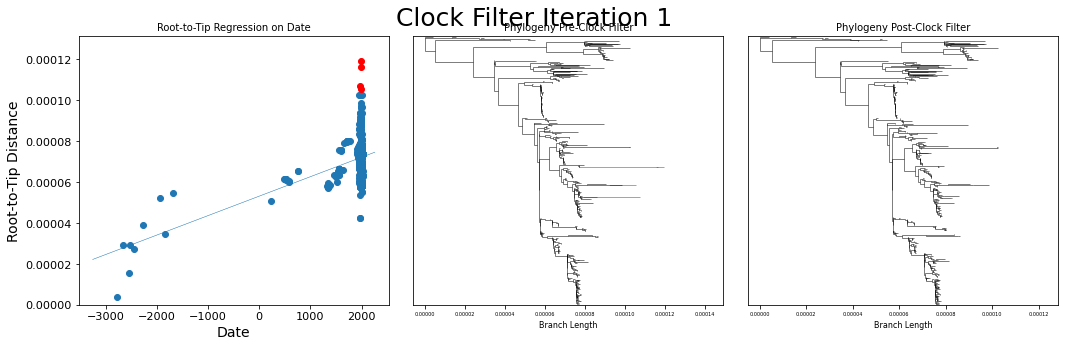

In [10]:
# Count the iterations needed
iter = 0
# A boolean to decide if we keep running the clock_filter
has_bad_branches = True

# Keep calculating and collapsing until no bad_branches
while has_bad_branches:
    
    iter += 1
    # Construct the treetime object
    # Remember, including the alignment is crucial!
    tt = treetime.TreeTime(dates=dates, 
                           aln=aln_path,                     
                           tree=tree_path, 
                           verbose=4, 
                           fill_overhangs=False,
                           seq_len=REF_LEN,                        
                          )

    # Remove outliers
    tt.clock_filter(reroot=None, 
                    n_iqd=N_IQD, 
                    plot=False,
                    )
        
    # Check rtt
    print("Clock Model: ", tt.date2dist.__dict__)
    has_bad_branches = True in [c.bad_branch for c in tt.tree.find_clades()]
    
    if has_bad_branches:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14.8,4.8))
        
        bad_clades = []

        for c in tt.tree.find_clades():
            if c.bad_branch:
                bad_clades.append(c.name)
                c.color = "red"
        
        # -----------------------------------------------------
        # Axis 1: Root To Tip Regression
        tt.plot_root_to_tip(add_internal=False, label=True, ax=ax1)
        # Labels
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Root-to-Tip Distance")
        ax1.set_title("Root-to-Tip Regression on Date")
        
        # -----------------------------------------------------
        # Axis 2: Tree Pre-Clock Filter
        Phylo.draw(tt.tree, 
            show_confidence=False, 
            #label_func = lambda x: x.name if x.name in bad_clades else None,
            label_func = lambda x: '',
            do_show=False,
            axes=ax2)
        
        ax2.set_xlabel("Branch Length")
        ax2.set_yticks([])
        ax2.set_ylabel('')
        ax2.set_title("Phylogeny Pre-Clock Filter")
        
        # Collapse
        for b in bad_clades:
            # Possibly already collapsed if redundancy
            try:
                b_node = tt.tree.common_ancestor([b])
                for c in b_node.find_clades():
                    print("Collapsed node {} in the tree.".format(c))
                    tt.tree.collapse(target=c.name)
            except ValueError:
                continue
        
        # Remove from dataframe
        for b in bad_clades:
            try:
                tree_df.drop(index=b, inplace=True)
                print("Dropped {} from the dataframe.".format(b))
            except KeyError:
                continue

        # -----------------------------------------------------
        # Axis 3: Tree Post-Clock Filter
        Phylo.draw(tt.tree, 
               show_confidence=False, 
               label_func = lambda x: x.name if x.name in bad_clades else None, 
               do_show=False,
               axes=ax3,
               )
        
        ax3.set_xlabel("Branch Length")
        ax3.set_yticks([])
        ax3.set_ylabel('')
        ax3.set_title("Phylogeny Post-Clock Filter")
        
        

        # Save new tree
        tree_path = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
        Phylo.write(tt.tree, tree_path, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))



---
# 1. Clock Analysis

In [ ]:
# Initialize stdout capture
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

# PARAM MIN: root='-4101-09-02'
tt.run()

#tt.run(root="SAMEA3541826")

# PARAM FULL: root=''
"""tt.run(
       Tc="skyline", 
       max_iter=MAX_ITER,
       relaxed_clock={"slack":5.0, "coupling": 0},
       infer_gtr=True,
       time_marginal=TIME_MARGINAL,
       sequence_marginal=SEQ_MARGINAL,
       verbose=4,
       resolve_polytomies=False,
       n_iqd=N_IQD,
       # branch_length_mode = "input",
       # root=None,
       # use_covariation=False,
       # vary_rate=False,
       )"""

# Save stdout to file
output = new_stdout.getvalue()
out_path = os.path.join(outdir, SCRIPT_NAME + ".log") 
with open(out_path, "w") as file:
    file.write(output)
    
# Restore stdout
sys.stdout = old_stdout
print("Standard output restored.")

In [ ]:
# Quick check 1
tt.tree.common_ancestor("NODE0")

In [ ]:
# Quick check 2
tt.clock_model

In [ ]:
# Quick check 3
Phylo.draw(tt.tree, 
       show_confidence=False, 
       label_func = lambda x:'', 
       do_show=False)

## Ladderize Tree

In [ ]:
tt.tree.ladderize(reverse=False)

---
# 2. Add clock stats to data frame

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [ ]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [ ]:
# Create new columns
tree_df["timetree_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_numdate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Optional confidence intervals if marginal prob was run
tree_df["timetree_numdate_lower"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_numdate_upper"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):    
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE) 
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_numdate_lower"] = conf[0]
        tree_df.at[c.name, "timetree_numdate_upper"] = conf[1]

    tree_df.at[c.name, "timetree_date"] = c.date  
    tree_df.at[c.name, "timetree_numdate"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

In [ ]:
tree_df

## Regression

In [ ]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

## Skyline

In [ ]:
if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=n_std)
print(skyline)
print(conf)

---
# Export

## Dataframe

In [ ]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## JSON

In [ ]:
clock_model_dict = {}
keys = ["slope", "intercept", "chisq", "r_val"]
for k in keys:
    clock_model_dict[k] = tt.clock_model[k]

out_path_json = os.path.join(outdir, SCRIPT_NAME + "_clock_model.json" )
with open(out_path_json, "w") as outfile:  
    json.dump(clock_model_dict, outfile, indent=4, sort_keys=True)

## Skyline

In [ ]:
if hasattr(tt, "merger_model"):
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )

    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )